In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import dataset
import rendering
from model import Voxels
import train

Instead of sphere with few parameters we'll have voxels with way more parameters.
our sphere model isnt complex enough to fit to enough scenes

Therefore we'll move to voxels to represent more scenes, and finally we'll move to Neural Networks that can represent even more complex scenes


## 1. Camera / Dataset

- Instrinsic: intrinsic paramters eg. the camera parameters the orientation, focal length etc.
for NeRF we make sure the intrinsic parameters like focal length are the same for input image while the position is changing overtime.

- do not use autofocus on your phone use the same focal length for all images.
- most nerf code assumes that intrinsic params between input images remain the same

In [2]:
BATCH_SIZE = 1024
origin, direction, target_px_values = dataset.get_rays('fox/',mode='train')

dataloader = DataLoader(torch.cat((torch.from_numpy(origin).reshape(-1, 3), # [N*H*W, 3]
                                   torch.from_numpy(direction).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                        batch_size=BATCH_SIZE, shuffle=True)

# Warmup to precent mode collapse into local minima by only taking the centre of the images
dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(origin).reshape(90, 400, 400, 3) [:, 100:300, 100:300, :].reshape(-1, 3), # [N*H*W, 3]
                                   torch.from_numpy(direction).reshape(90, 400, 400, 3) [:, 100:300, 100:300, :].reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(90, 400, 400, 3) [:, 100:300, 100:300, :].reshape(-1, 3)), dim=1),
                        batch_size=BATCH_SIZE, shuffle=True)

test_origin, test_direction, test_target_px_values = dataset.get_rays('fox/', mode='test')


print(f"origin shape: {origin.shape}")
print(f"direction shape: {direction.shape}")
print(f"target_px_values shape: {target_px_values.shape}")
print(f"test_origin shape: {test_origin.shape}")
print(f"test_direction shape: {test_direction.shape}")
print(f"test_target_px_values shape: {test_target_px_values.shape}")

Mode: train
Image files length: 90
Pose files length: 90
Intrinsic files length: 90
Image size: (400, 400, 4)
(90, 400, 400, 4)
Mode: test
Image files length: 10
Pose files length: 10
Intrinsic files length: 10
Image size: (400, 400, 4)
(10, 400, 400, 4)
origin shape: (90, 160000, 3)
direction shape: (90, 160000, 3)
target_px_values shape: (90, 160000, 3)
test_origin shape: (10, 160000, 3)
test_direction shape: (10, 160000, 3)
test_target_px_values shape: (10, 160000, 3)


## 2. Rendering

## 3. Model

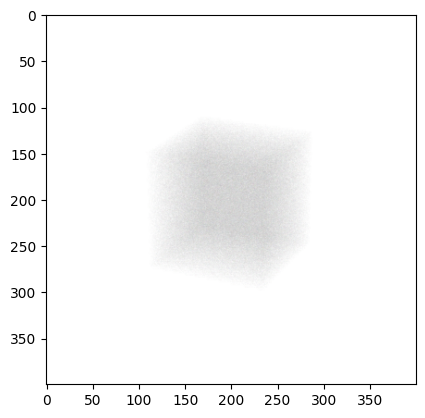

In [3]:
test_model = Voxels(scale=1)
img = rendering.rendering(test_model, torch.from_numpy(origin[0]), torch.from_numpy(direction[0]), 8, 12, white_background=True)
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())

In [4]:
for params in test_model.parameters():
    print(params)

Parameter containing:
tensor([[[[4.5362e-01, 4.3084e-01, 2.1270e-01, 1.5048e-01],
          [8.2035e-01, 8.7259e-01, 3.5476e-01, 2.7748e-01],
          [1.3431e-01, 3.1432e-01, 6.4490e-01, 2.8472e-01],
          ...,
          [7.3244e-01, 8.6823e-01, 6.9022e-01, 8.8212e-01],
          [6.0924e-01, 7.9914e-01, 8.1802e-01, 8.2311e-01],
          [2.3257e-01, 2.6238e-01, 2.5641e-01, 3.1257e-01]],

         [[7.0870e-01, 3.1039e-01, 7.4998e-02, 7.0822e-01],
          [4.2856e-01, 4.6307e-01, 8.8045e-01, 5.9237e-03],
          [4.0158e-01, 4.8951e-01, 2.2585e-01, 7.3407e-01],
          ...,
          [1.9064e-01, 6.8794e-01, 2.8037e-01, 2.0131e-01],
          [4.6665e-01, 7.9291e-01, 2.1574e-01, 4.2283e-01],
          [3.0962e-01, 4.5595e-01, 7.8623e-01, 2.9339e-01]],

         [[5.0137e-01, 2.6241e-01, 6.1910e-01, 3.2948e-01],
          [4.1303e-01, 7.7643e-01, 4.6052e-03, 2.7187e-01],
          [8.3110e-01, 1.0211e-01, 3.0393e-01, 4.3163e-01],
          ...,
          [5.0739e-01, 8.9830

## 4. Training

100%|██████████| 3516/3516 [00:42<00:00, 83.06it/s] 


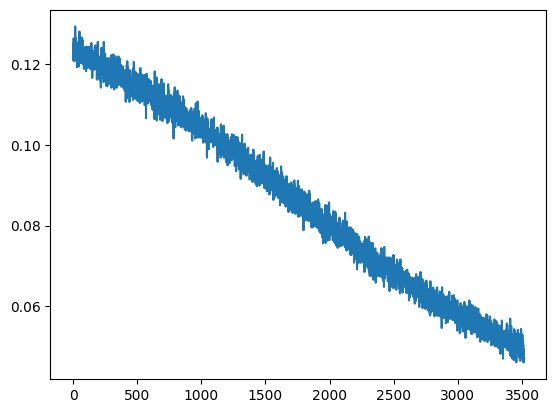

 70%|██████▉   | 9844/14063 [02:18<01:03, 66.34it/s] 

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparams
tn = 8
tf = 12
nb_epochs = 15
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

model = Voxels(scale=3, device=device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [5, 10], gamma=gamma)


#warmup on 1 epoch
training_loss = train.training(model, optimizer, scheduler, dataloader_warmup, tn, tf, nb_bins, 1, device)
plt.plot(training_loss)
plt.show()

training_loss = train.training(model, optimizer, scheduler, dataloader, tn, tf, nb_bins, nb_epochs, device)

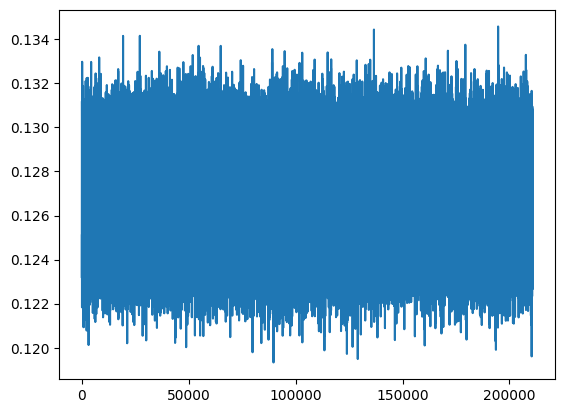

In [ ]:
plt.plot(training_loss)

In [ ]:
img = rendering.rendering(model, torch.from_numpy(origin[0]).to(device), torch.from_numpy(direction[0]).to(device), tn, tf, nb_bins = 100, device = device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

## Fix mode collapse on synthetic data
- in a mini batch we may get a lot of pixels that have the value zero (with white background regularization) therefore we have have mode collapse at zero ie. it outputs zero for any values. Therefore we are stuck in a local minima

### solutions:
- use TruncExp() used in instantngp
- use softprus
- on the first epoch only trian on the centre of the image
